In [1]:
source('simData.R')
library(WGCNA)
library(randomForest)
library(fuzzyforest)
library(dplyr)

Warning message:
"package 'WGCNA' was built under R version 3.6.1"Loading required package: dynamicTreeCut
Loading required package: fastcluster

Attaching package: 'fastcluster'

The following object is masked from 'package:stats':

    hclust


Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'WGCNA'

The following object is masked from 'package:stats':

    cor

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.
Warning message:
"package 'fuzzyforest' was built under R version 3.6.1"
Attaching package: 'dplyr'

The following object is masked from 'package:randomForest':

    combine

The following object is masked from 'package:MASS':

    select

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



# 1. Data

In [2]:
n= 100   #number of patients
T = 5  # number of observations per patient
p = 400 # number of features

set.seed(100)
data <- sim_3(n,T,cor_feature = 0.8) # generate AR data set with random effect (use sim_3() for no RE)
#data <- sim_2(n,T,cor_feature = 0.8) # genearate CS  data set (no random effect)


X = data[,-ncol(data)] # remove y value from for X matrix
X = data.frame(X)
y = data[,ncol(data)] # assign target variable

In [3]:
n_test= 30   #number of patients
T = 5  # number of observations per patient
p = 400 # number of features

set.seed(101)
data_test <- sim_3(n_test,T,cor_feature = 0.8) # generate AR data set with random effect (use sim_3() for no RE)
#data <- sim_2(n,T,cor_feature = 0.8) # genearate CS  data set (no random effect)


X_test = data_test[,-ncol(data_test)] # remove y value from for X matrix
X_test = data.frame(X_test)
y_test = data_test[,ncol(data_test)] # assign target variable

# Fuzzy Forest

In [4]:
n_run = 50 # the number of times RF will run on the data set
n_top = 10 # the top n_top variables will be selected

In [5]:
select_params <- select_control(number_selected = n_top) # select number of important features to keep

In [6]:
# create empty data frame to save simulation results in
result_ff = matrix(0,n_run+1,400+1) # the last row is for average
result_ff = data.frame(result_ff)
names(result_ff)[401] = "error"
names(result_ff)[1:400] = paste("V",1:400,sep="")
result_ff[1:5,]

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V392,V393,V394,V395,V396,V397,V398,V399,V400,error
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
system.time({
for(Repeat in 1:n_run){
  set.seed(Repeat+34) # change seed each loop

  ff <- wff(X,y, select_params = select_params)
  
  top_variables = ff$feature_list[,1]
  
  # error on the test set
  preds <- predict(ff, new_data=X_test)
  error = sum((y_test-preds)^2)/(n_test*T)
  
  # If variable was selected as important, indicate with 1 (otherwise 0)
  for (i in 1:400){
      result_ff[Repeat,i] <- as.numeric(paste("X",i,sep="") %in% top_variables)
  }
  result_ff[Repeat,401] <- error
    
  # show the progress
  flush.console()
  cat(Repeat,"\n")
}
})

result_ff[n_run+1,] = colMeans(result_ff[1:n_run,])
write.csv(result_ff,file = 'results_ff.csv')

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 
31 
32 
33 
34 
35 
36 
37 
38 
39 
40 
41 
42 
43 
44 
45 
46 
47 
48 
49 
50 


   user  system elapsed 
8059.14  131.05 9149.52 

In [9]:
# The final result after N_run times
result_ff[n_run+1,]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V392,V393,V394,V395,V396,V397,V398,V399,V400,error
51,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,22.32743


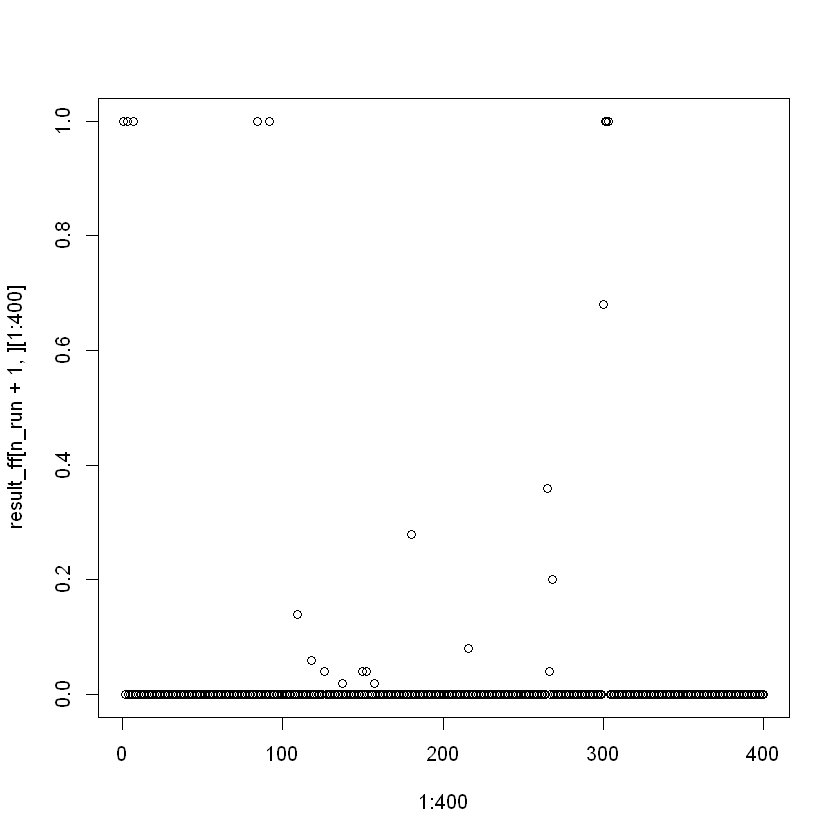

In [10]:
plot(1:400,result_ff[n_run+1,][1:400])

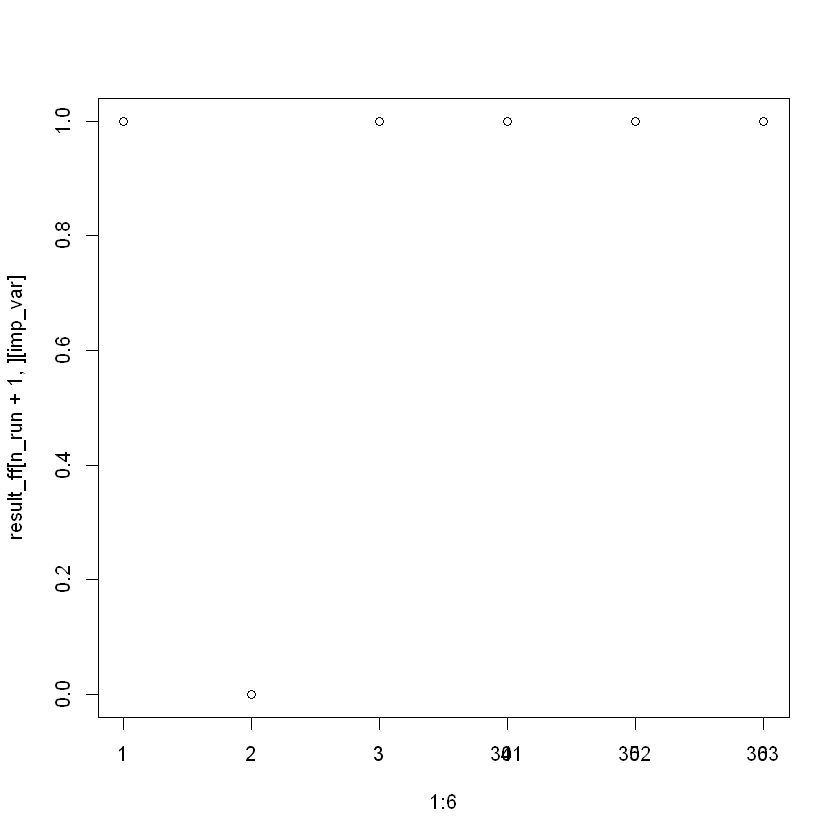

In [11]:
imp_var = c(1,2,3,301,302,303)
plot(1:6,result_ff[n_run+1,][imp_var])
axis(1, at=1:6, labels=imp_var)

In [12]:
sort(result_ff[n_run+1,][1:400],index.return=TRUE,decreasing = TRUE)[1:20]

,V1,V3,V7,V84,V92,V301,V302,V303,V300,V265,V180,V268,V109,V216,V118,V126,V150,V152,V266,V137
51,1,1,1,1,1,1,1,1,0.68,0.36,0.28,0.2,0.14,0.08,0.06,0.04,0.04,0.04,0.04,0.02
